<h1 align="center"> IRIS data set </h1>

Download the IRIS data set from: <p></p>
 https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data <p></p>
 
 This is a data set of 150 points in R<sup>4</sup>, with three classes; refer to the website for more details of the features and classes. <p></p>
 
 <b>(a)</b> Use a PCA projection to 2d to visualize the entire data set. You should plot different classes using different colors/shapes. Do the classes seem well-separated from each other? <p></p>
 
 <b>(b)</b> Now build a classifier for this data set, based on a generative model. 


In [140]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

## Importing iris dataset

In [141]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data -O iris.txt

--2016-03-13 15:56:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4551 (4.4K) [text/plain]
Saving to: `iris.txt'

100%[======================================>] 4,551       --.-K/s   in 0s      

2016-03-13 15:56:40 (155 MB/s) - `iris.txt' saved [4551/4551]



## (a) Read Data and Perform PCA  to 2 components

In [142]:
df = pd.read_csv('iris.txt', names=['sepal_len','sepal_wid','petal_len','petal wid','class'])
pca = PCA(n_components = 2)
pca.fit(df.ix[:,0:4].values)
X = pca.transform(df.ix[:,0:4].values)
df['P1'] = X[:,0]
df['P2'] = X[:,1]
df.head()

,sepal_len,sepal_wid,petal_len,petal wid,class,P1,P2
0,5.1,3.5,1.4,0.2,Iris-setosa,-2.684207,-0.326607
1,4.9,3.0,1.4,0.2,Iris-setosa,-2.715391,0.169557
2,4.7,3.2,1.3,0.2,Iris-setosa,-2.889820,0.137346
3,4.6,3.1,1.5,0.2,Iris-setosa,-2.746437,0.311124
4,5.0,3.6,1.4,0.2,Iris-setosa,-2.728593,-0.333925


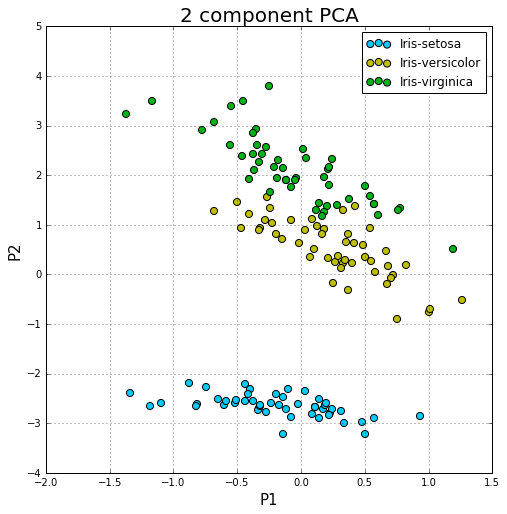

In [143]:
classes = df['class'].unique()
colors = [(0,.8,1),'y',(0,.7, .1)]
plt.figure(figsize = (8,8))
plt.xlabel('P1', fontsize = 15)
plt.ylabel('P2', fontsize = 15)
plt.title('2 component PCA', fontsize = 20)
for cl, color in zip(classes,colors):
    P1 = df[df['class'] == cl]['P1'].values
    P2 = df[df['class'] == cl]['P2'].values
    plt.scatter(P2, P1, c = color, s = 50)
plt.legend(classes)
plt.grid()

The three classes appear to be well separated! 

iris-virginica and iris-versicolor could be better separated, but it is good!

## (b) Train with Multivariate Gaussian Classifier

In [144]:
#training dataset
df_train = df[df['class'] == classes[0]][0:35]
for c in classes[1::]:
    df_train = pd.concat([df_train, df[df['class'] == c][0:35]])

#test dataset
df_test = df[df['class'] == classes[0]][35::]
for c in classes[1::]:
    df_test = pd.concat([df_test, df[df['class'] == c][35::]])

In [150]:
def classify(sample_df, valid_df):

    prob = []

    #Find probability of each classifier
    for i in xrange(3): 
        cond = sample_df['class'] == classes[i]
        mean = np.mean(sample_df[cond].ix[:,0:4].values, axis = 0)
        cov = np.cov(np.transpose(sample_df[cond].ix[:,0:4].values))
        func = multivariate_normal(mean=mean, cov=cov)
        prob.append(func.logpdf(valid_df.ix[:,0:4]))

    #Take the max pdf
    max_prob = np.argmax(prob, axis = 0)
    tf_number_error = [classes[i] != j for i,j in zip(max_prob, valid_df['class'])]
    #Compare with valid target to get error
    error_percent = np.sum(tf_number_error)/len(valid_df)
    return error_percent

## Train the dataset

In [146]:
def find_error(sample_df, valid_df):

    prob = []

    #Find probability of each classifier
    for i in xrange(3): 
        cond = sample_df['class'] == classes[i]
        mean = np.mean(sample_df[cond].ix[:,0:4].values, axis = 0)
        cov = np.cov(np.transpose(sample_df[cond].ix[:,0:4].values))
        func = multivariate_normal(mean, cov)
        prob.append(func.logpdf(valid_df.ix[:,0:4]))

    #Take the max pdf
    max_prob = np.argmax(prob, axis = 0)
    #Compare with valid target to get error

    label = []
    flower = []
    prob = np.matrix(prob)
    for i,j,k in zip(max_prob, valid_df['class'], range(len(valid_df))):
        if  classes[i] != j:
            flower.append(j)
            label.append(classes[i])
    return [flower, label]

In [147]:
#Get values
[flower, label] = find_error(df_train, df_train)

In [148]:
#Create dataframe of flowers and predictions
error_df1 = pd.DataFrame({'prediction': label, 'flower': flower})
error_df1.head()

,flower,prediction
0,Iris-versicolor,Iris-virginica
1,Iris-virginica,Iris-versicolor


## Test Dataset

In [149]:
error_percent = classify(df_train, df_test)

print('Error:',error_percent)

('Error:', 0)


100% accuracy with 0 percent error on our test dataset.